# Titanic Machine Learning
### Tony Reina
### Last update: 12 Oct 2016
#### Here's the Titanic machine learning dataset from [Kaggle](https://www.kaggle.com/c/titanic). I'm analyzing it using Scikit-Learn's Adaptive Boost [adaboost](http://scikit-learn.org/stable/modules/ensemble.html#adaboost).

The Titanic dataset is a good set to start learning data science. It's small enough to work through in a single day (or two). It has mixed data types (numeric and non-numeric). It has missing values and errorneous data to handle. And-- even with the simplest of data analysis techniques-- you can get a prediction accuracy greater than 70% without a lot of effort.  

## Import the python libraries

First, we just need to import the Python libraries for loading and pre-processing datasets ([pandas](http://pandas.pydata.org/), [numpy](http://numpy.org)) and plotting data ([matplotlib](http://matplotlib.org) and [seaborn](https://pypi.python.org/pypi/seaborn)). Strictly speaking, you don't need the plotting stuff to run the code; however, good analysis demands that we visually inspect the data before we run it through models. The better we can pre-process the data (i.e. determine possible trends, identify possibly significant variables, remove/handle missing values), the better our model will be.

In [1]:
import pandas as pd              # pandas is great for managing datasets as a single object
import numpy as np               # numpy has great matrix/math operations on arrays

import matplotlib.pyplot as plt  # allows you to print figures and charts
import seaborn as sns            # a fancy chart add-on for matplotlib

# This command creates the figures and charts within the Jupyter notebook
%matplotlib inline     

## Pre-processing functions
These functions are used to pre-process the data (which is stored in a Pandas dataframe, `df`). According to the [Kaggle website](https://www.kaggle.com/c/titanic/data), the data looks like this:

| Variable Name  | Description                        | Type |
| -------------- | ---------------------------------- | ---- |
| survival       | Survival  (**Our model tries to predict this based on the other variables.**)                         | number  |
|                | Values: (0 = No; 1 = Yes)                  | 
| pclass         | Passenger Class                    | number  |
|                | Values: (1 = 1st; 2 = 2nd; 3 = 3rd)  |
| name           | Name                               | string |
| sex            | Sex                                | string |
|                | Values: (female, male) | 
| age            | Age                                | number |
| sibsp          | Number of Siblings/Spouses Aboard  | number |
| parch          | Number of Parents/Children Aboard  | number |
| ticket         | Ticket Number                      | string |
| fare           | Passenger Fare                     | number |
| cabin          | Cabin                              | string |
|embarked        | Port of Embarkation                | character |
|                | Values: (C = Cherbourg; Q = Queenstown; S = Southampton) |

For example, in one function, we replace the text values for the 'Embarked' field with numbers. For example, the embarkation port labeled 'S' becomes 0, 'C' becomes 1, and 'Q' becomes 2.

Later on in this notebook, we'll use the [scikit-learn package](http://scikit-learn.org) to create models for the data. Scikit-learn assumes that your data is all numbers-- *it can't read text*. So we need to substitute number assignments for the text fields. For example, for the sex field, we can replace the values 0 for females and 1 for males; or, we can have 34 for males and 123 for females (or -7.8 for males and 999.123 for females). The number doesn't matter so long as it is consistent-- males get one number and females get a different number. This should be done for an non-numeric field.

We also have functions which replace the missing data (NaN) with the mean or median value within that data field. Sometimes we even drop fields if they have too many missing values or if they can't possibly be associated with the prediction. For example, the name of the person probably doesn't predict if they survived, but their age probably does.

In [2]:
'''
This calls all of the preprocessing functions.
Preprocessing should be done exactly the same on both the training and testing data sets.
'''

def preprocessData(df):
    
    # Convert the embarkation field from categorical ("S", "C", "Q")
    # to numeric (0,1,2)
    df = convertEmbarked(df)
    
    # Convert sex. Female = 0, Male = 1
    df = convertSex(df)

    df = addFamilyFactor(df)
    
    df = addTitles(df)

    # Remove irrelevant and non-numeric columns (features)
    df = df.drop(['Name', 'Cabin', 'PassengerId', 'Ticket'], axis=1) 

    # Replace the missing values (NaN) with the mean value for that field
    df = replaceWithMean(df)

    return df

In [3]:
'''
Convert the sex field to numeric
'''
def convertSex(df):
    
    # Convert the 'male'/'female' strings to integer classifiers.
    # Female = 0, Male = 1
    # Create a new column called "Gender" which is a mapping of the "Sex" column into integer values
    df["Gender"] = df["Sex"].map( {"female": 0, "male": 1} ).astype(int)
    # Now drop the "Sex" column since we've already replaced it by the integer column "Gender"
    df = df.drop(['Sex'], axis=1)
    
    return df
    

In [4]:
'''
Scikit-learn can only handle numbers.
So let's replace the text values for the 'Embarked' field with numbers. 
For example, the embarkation port labeled 'S' becomes 0, 'C' becomes 1, and 'Q' becomes 2.
'''
def convertEmbarked(df):
    
    if ('Embarked' in df.columns) :  # If the field 'Embarked' is in the pandas dataframe df
        
        # missing value, fill na with most often occured value
        if (len(df[df["Embarked"].isnull()]) > 0):

            # We need to get rid of missing values (not-a-number, NaN)
            # http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.mode.html
            # If you want to impute missing values with the mode in a dataframe df, you can just do this:
            df.loc[df["Embarked"].isnull(), 'Embarked'] = df["Embarked"].dropna().mode().iloc[0]

        ports = list(enumerate(np.unique(df["Embarked"])))  # Get the list of unique port IDs
        port_dict = { name: i for i, name in ports } # Create a dictionary of the different port IDs
        df["Embarked"] = df["Embarked"].map( lambda x: port_dict[x]).astype(int)  # Reassign the port IDs to numbers
        
    return df

#### Titles
The `Names` field of our data includes titles. So perhaps someone like _Duff Gordon, Lady. (Lucille Christiana Sutherland)_ will get a lifeboat before _Dooley, Mr. Patrick_ (apologies to Mr. Dooley). Of course, that's a guess, but it's probably a good one knowing a little bit about the tragic event. If that's the case, then let's parse the `Name` field for titles and add a new column called `Titles` which has a numeric value based on how important we think the person is.

In [5]:
def addTitles(df):
    
    # we extract the title from each name
    combined = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated titles
    Title_Dictionary = {
                        "Capt":       1,
                        "Col":        1,
                        "Major":      1,
                        "Jonkheer":   3,
                        "Don":        3,
                        "Sir" :       3,
                        "Dr":         2,
                        "Rev":        1,
                        "the Countess":3,
                        "Dona":       3,
                        "Mme":        0,
                        "Mlle":       0,
                        "Ms":         0,
                        "Mr" :        0,
                        "Mrs" :       0,
                        "Miss" :      0,
                        "Master" :    1,
                        "Lady" :      3

                        }
    
    # we map each title
    df['Title'] = combined.map(Title_Dictionary)
    
    return df

In [6]:
'''
Replace any missing values (NaN) with the mean value for that column
'''
def replaceWithMean(df):
    
    # Replace all NaNs in a Dataframe with the mean of that column (field).
    # I think this only works for numbers (int, float) 
    # You should do this as the last step of pre-processing in case you want to replace the NaNs
    # with some other method. Once you run this, all of the NaNs in the dataframe are gone.
    df = df.fillna(df.mean())
    return df

In [7]:
'''
There are two "family" variables in the original data. This combines them both into one variable.
'''
def addFamilyFactor(df):
    # Add a category called FamilyFactor
    # Perhaps people with larger families had a greater probablity of rescue?
    # If I just add the two together, then the new catgegory is just a linear transform and
    # won't really add new info. So I add and then square the value. 
    df['FamilyFactor'] = np.power(df.SibSp + df.Parch, 2)
    
    return df

### Read the training data
The following cells read in the training data from the comma-separated data file `train.csv`. We're using pandas to store the data as an object because pandas is really good at data manipulation and many other libraries (numpy/scikit/matplotlib) work well with pandas objects.

In [8]:
'''
Read the training data from csv file
'''
train_df = pd.read_csv('../input/train.csv', header=0, dtype={"Age": np.float64})  # Load the train file into a dataframe

# Get the basic info for the data in this file
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Use Seaborn (matplotlib wrapper) to print pretty pictures of our raw data
Here we show how to plot the raw data from the 'Embarked' variable. Note that if you embarked at 'C' (Cherbourg), then you had a better than 50% chance of surviving whereas the other two ports had less than 40% chance of surviving. It's not a huge correlation, but it might be helpful when combined with other features. So embarkation site might be a useful feature to use in our prediction model.

You can try this approach on the other variables (e.g. sex, age) to see how they influence the survival rate. This is one method to select which features (i.e. fields/columns) you'll use in the final model.

Remember, the [adaptive boosting](https://en.wikipedia.org/wiki/AdaBoost) method is good at taking weak classifiers and combining them (in a weighted way) to create strong prediction models. So many poorly-correlated variables might be as useful as a strongly-correlated one.

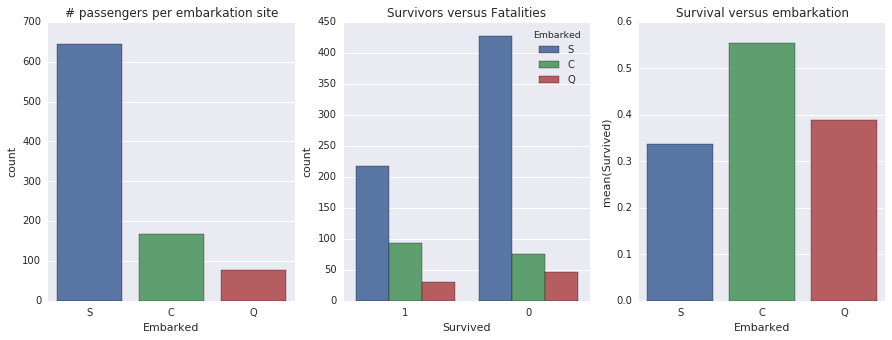

In [9]:
# Setup a plot with 3 subplots side by side
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

# Count plot of how many people embarked at each location
# countplot is for categorial data, barplot for quantitative data
sns.countplot(x="Embarked", data=train_df, ax=axis1)
axis1.set_title("# passengers per embarkation site")

# Comparing survivors versus fatalities as a function of embarkation
sns.countplot(x="Survived", hue="Embarked", data=train_df, order=[1,0], ax=axis2)
axis2.set_title("Survivors versus Fatalities")

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = train_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)
axis3.set_title("Survival versus embarkation")

### Pre-process the data
We need to do something with the missing values, text strings, and irrelevant fields.

In [10]:
train_df = preprocessData(train_df)

In [11]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Gender,FamilyFactor,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.536476,0.647587,3.418631,0.089787
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429,0.791503,0.477990,11.181689,0.362291
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,1.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200,2.000000,1.000000,0.000000,0.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,2.000000,1.000000,1.000000,0.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,2.000000,1.000000,100.000000,3.000000


# [AdaBoost (Adaptive Boost)](https://en.wikipedia.org/wiki/AdaBoost)
## It's modeling time.
Let's create an AdaBoost classifier to model the training data. Adaboost is a meta-algorithm for machine learning. So it's not an actual machine learning model, but rather a way to combine machine learning models. AdaBoost takes an ensemble other machine learning classifiers (e.g. regression, b-trees, random forests, neural networks) and combines them in a weighted fashion to create a new classifier. So it is like taking several weak predictive models and combining them to form one super model.

For example, let's say we have 5 neural networks that predict a binary output (0 or 1). So each of the 5 neural nets produce a prediction for us but each is set up in a different way (different layers, different inputs, etc). But, let's say that none of these neural networks are really good predictors. Adaboost is a way to combine all 5 neural networks into a single model that gives a better prediction than any one model alone (the sum is greater than the parts).

For binary classifiers, an error rate of 50% is just like flipping a coin-- it's the worse you can do since it is completely random (if you are worse than 50%, then you should just guess the opposite of whatever the model predicts!). Any model that has an error rate close to 50% (e.g. 43%) is considered a "weak" predictive model. Any model that is close to a 0% prediction error (e.g. 9%) is considered a "strong" predictive model.

AdaBoost takes our 5 "weak" neural networks, multiplies their output (0-1) by some scaling factor, adds the result, and then determines if that is above a certain threshold. So it's a linear summation of each individual model. It's sort of like the "Poll the Audience" lifeline in "Who Wants to Be a Millionaire?" Every model gets a vote and the votes are tallied to give a prediction. However, in AdaBoost, each vote is weighted depending on the strength of the voter (i.e. the individual model). So one person might be smart, but a lot of semi-smart people can be geniuses if they work together to come up with an answer.

In [12]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC

# The data is now ready to go. So lets fit to the train, then predict to the test!
# Convert back to a numpy array
train_data = train_df.values
train_features = train_data[0::,1::]   # The features to use for the prediction model (e.g. age, family size)
train_result = train_data[0::,0]       # The thing the model predicts (i.e. survived)

print('Training with model. Please WAIT ...')

# Adaboost using a bunch of RandomForest models
# SAMME — Stagewise Additive Modeling using a Multi-class Exponential loss function 
# Zhu, H. Zou, S. Rosset, T. Hastie, “Multi-class AdaBoost”, 2009.
# For more info, http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_multiclass.html
model = AdaBoostClassifier(RandomForestClassifier(n_estimators = 1000),
                         algorithm="SAMME",
                         n_estimators=500)

# Here's how to do a Random Forest
#model = RandomForestClassifier(n_estimators=1000).fit(train_features, train_result)

# Here's a support-vector machine model (SVM)
#model = SVC(probability=True,random_state=1)

# Fit the training data to the Adaboost model
model = model.fit(train_features, train_result)

print ('Ok. Finished training the model.')

Training with model. Please WAIT ...
Ok. Finished training the model.


### Accuracy
So how good is this model? Well, compute how well our predictions matched with the known values. This is called accuracy (or conversely error).

In [13]:
from sklearn.metrics import accuracy_score

print ('Accuracy = {:0.2f}%'.format(100.0 * accuracy_score(train_result, model.predict(train_features))))

Accuracy = 98.43%


### Cross-validation
Your accuracy shows that got a *really* good model, right?

Well, not so fast.

Accuracy is really deceptive. Remember, you are fitting the curve to the data. You expect a good fit to that data. Sometimes, you can fit the data so well that the model only really works on that specific data set. This is called _overfitting_. So to really test the true accuracy of your brand new model, you need to test the model on new data (i.e. data you didn't train the model on).

[Cross validation](http://scikit-learn.org/stable/modules/cross_validation.html) gives you an idea of how good the model predicts new data. The scikit-learn module `model_selection` has a function called `cross_val_score` which returns the accuracy of the model. It does this by randomly splitting your data into two sets (aka k-folds). One set will be used to train the model. The other set will be used to test how accurate that model is. This helps us identify overfitting. Many models can perfectly fit the dataset during training, but be so specific to that dataset that they fail when they see new data.

In [14]:
from sklearn.model_selection import cross_val_score

# Calculating cross-validation of the training model
print ('Calculating cross-validation of the training model. Please WAIT ...')

# Cross-validation with k-fold of 5. So this will randomly split the training data into two sets.
# It then fits a model to one set and tests it against the other to get an accuracy.
# It will do this 5 times and return the average accuracy.
scores = cross_val_score(model, train_features, train_result, cv=5)
print ( 'On average, this model is correct {:0.2f}% (+/- {:0.2f}%) of the time.'.format(
        scores.mean() * 100.0, scores.std() * 2 * 100.0))

Calculating cross-validation of the training model. Please WAIT ...
On average, this model is correct 80.70% (+/- 4.96%) of the time.


### How'd you do?
Was the cross-validation disappointing? Did the cross-validation accuracy fall? It typically does. This is the science part of data science. To get better accuracy and better predictions, you need to:

1. work with the feature set - Do all of your features help in the prediction? Are their transformations in those features which will make them work even better.

2. try out new models - Is SVM more appropriate? Neural nets? Random forests? Little bubbly bears?

This is where Jupyter shines. You can keep playing with the dataset and the model until you get your best result. And, you can document your process along the way.

### Get the testing data
Now read in the test data. That's the data where we don't know the result (i.e. no 'Survived' field). We'll use the trained model on that data to predict the value and send that to Kaggle.

In [15]:
# Import the test data into a Pandas dataframe
test_df = pd.read_csv('../input/test.csv', header=0, dtype={"Age": np.float64})        # Load the test file into a dataframe

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### Pre-processing
I need to preprocess this data exactly like I pre-processed the training set data. If I don't, then the model won't work correctly.

In [16]:
# Grab the passenger Ids first since they are removed by the pre-processing function
testIds = test_df['PassengerId']

test_df = preprocessData(test_df)

### Prediction Time

Now use the Testing data and predict the output (survived) based on the model we've created from the training data. Amazingly, this just takes one line. Scikit-learn does the rest for you.

In [17]:
print('Predicting the survival from the test data. PLEASE WAIT... ', end='') # Supress newline with end=''

test_predictions = model.predict(test_df.values)

print('DONE')

Predicting the survival from the test data. PLEASE WAIT... DONE


## Send the predictions to [Kaggle](https://www.kaggle.com/c/titanic)
Now that we have the model's predictions on the test data, let's save it in a comma-separated value (csv) file for uploading to [Kaggle](https://www.kaggle.com/c/titanic).

In [18]:
# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({"PassengerId" : testIds.astype(int),
                           "Survived" : test_predictions.astype(int)})

# Save the submission to CSV file
submission.to_csv("titanic_submission", index=False)

## You're done.
Now you just need to upload the file `titanic_submission` to Kaggle and see how you do. 

A very simple prediction model can usually score with about a 70-80% accuracy. By playing around with models and features, you can bump that performance up to about 90%.